# Challenge 2

Our characters have gathered a collection of text files from the internet using the `la eterna` keyword and they want to get a general understanding of the various topics that are present in these articles. The data science term for this task is Topic Modeling and there are many different techniques to create and visualize topic models. This tutorial will focus on a specific method called Latent Dirichlet Allocation (LDA) and will present some different methods of visualizing and exploring the topics that it generates.

### Load Libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import re
import os
warnings.simplefilter('ignore')

# WordCloud 
from wordcloud import WordCloud, STOPWORDS

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Gensim
import gensim, spacy, logging, warnings
import en_core_web_sm
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

"""
# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Pyldavis 
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn

"""

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sagnikhalder/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'\n# Sklearn\nfrom sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer\nfrom sklearn.decomposition import LatentDirichletAllocation\n\n# Pyldavis \nimport pyLDAvis\nimport pyLDAvis.gensim_models\nimport pyLDAvis.sklearn\n\n'

## Load Dataset

In [2]:
project_dir = 'challenge2-articles'

In [3]:
# gets files from article directory
fns = []
for file_name in os.listdir(project_dir):
    if file_name.endswith('.txt'):
        fns.append(os.path.join(project_dir,file_name))

In [4]:
# this opens the txt files and appends the text files to the text dataframe 
df_txt = pd.DataFrame(columns=['fn', 'txt'])
for idx, fn in enumerate(fns):  
    print(fn)
    x = open(fn, mode="r", encoding="utf-8")
    x = x.read()  
    _df_txt = pd.DataFrame([[idx, x]],columns=['fn', 'txt'])
    df_txt = df_txt.append(_df_txt)
df_txt = df_txt.reset_index(drop=True) 

challenge2-articles/challenge2-article077.txt
challenge2-articles/challenge2-article063.txt
challenge2-articles/challenge2-article088.txt
challenge2-articles/challenge2-article103.txt
challenge2-articles/challenge2-article117.txt
challenge2-articles/challenge2-article116.txt
challenge2-articles/challenge2-article102.txt
challenge2-articles/challenge2-article089.txt
challenge2-articles/challenge2-article062.txt
challenge2-articles/challenge2-article076.txt
challenge2-articles/challenge2-article060.txt
challenge2-articles/challenge2-article074.txt
challenge2-articles/challenge2-article048.txt
challenge2-articles/challenge2-article114.txt
challenge2-articles/challenge2-article100.txt
challenge2-articles/challenge2-article128.txt
challenge2-articles/challenge2-article129.txt
challenge2-articles/challenge2-article101.txt
challenge2-articles/challenge2-article115.txt
challenge2-articles/challenge2-article049.txt
challenge2-articles/challenge2-article075.txt
challenge2-articles/challenge2-art

In [5]:
df_txt

,fn,txt
0,0,This is when the arthritis starts. A cheese t...
1,1,"Just like the other animals on this list, the..."
2,2,No better way to spend your days off than rese...
3,3,"In my garden, I grow a lot of medicinal plants..."
4,4,I was hiking through the canyon and found this...
...,...,...
140,140,La Eterna This flower was said to cure aging...
141,141,Is it legal to transport wild shrubs from La E...
142,142,My grandmother told me a story about a shrub s...
143,143,You can use this milk to make the most decade...


## Preprocess Text Files
Inspired by https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [6]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub(r'\s+', ' ', sent)  # remove newline chars
        sent = re.sub(r"\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)   

def process_words(data_words, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    # initialize bigram and trigram models 
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    monogram_texts = []
    for doc in data_words:
        doc_texts = []
        for word in simple_preprocess(str(doc)):
            if word not in stop_words:
                doc_texts.append(word)
        monogram_texts.append(doc_texts)
    texts_with_bigram = []
    for doc in monogram_texts:
        texts_with_bigram.append(bigram_mod[doc])
    texts = []
    for doc in texts_with_bigram:
        texts.append(trigram_mod[bigram_mod[doc]])
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out    

In [7]:
# takes the text dataframe, extracts the sentences and breaks the sentences into words
data = df_txt['txt'].values
data_words = list(sent_to_words(data))   

# removes stop words, forms bigrams, trigrams, lemmatizations
texts = process_words(data_words)

## Basic WordCloud Visualization

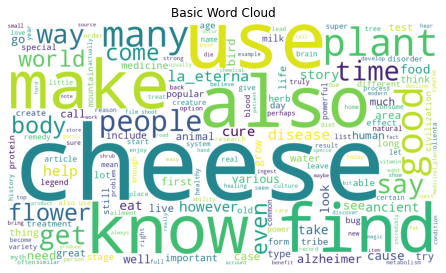

In [9]:
# explore the cleaned words dataset 
wordcloud_texts = [y for x in texts for y in x]
text_describe = pd.Series(wordcloud_texts)
wordcloud_texts = ' '.join(wordcloud_texts)
wordcloud = WordCloud(width=1280, height=720, background_color='white', stopwords=stop_words).generate(wordcloud_texts)
plt.imshow(wordcloud)
plt.title("Basic Word Cloud")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Build Initial Topic Model

In [10]:
# get unique IDs for words 
id2word = corpora.Dictionary(texts)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

num_topics=10
# Build LDA model
# update_every is for iterative learning (as opposed to batch learning) 
# chunksize is amount of data to use to train on each pass (using all given files)
# passes is amount of times to pass through the corpus 
# alpha is the prior, "symmetric" is a 1/num_topics 
# per_word_topics returns a list of likely topics (as opposed to the top topic)
ldamodel = (gensim
            .models
            .ldamodel
            .LdaModel(corpus=corpus, id2word=id2word,
                      num_topics=num_topics, random_state=100,
                      update_every=1, chunksize=len(fns), 
                      passes=100, alpha='symmetric', 
                      per_word_topics=True))

# passes data through the LDA model, identifies the topic of each sentence 
df_topics = pd.DataFrame()
for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list            
    # print(row)
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            df_topics = df_topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break
df_topics.columns = ['dominant_topic', 'contribution%', 'keywords']
df_topics['text'] = pd.Series(data)

In [11]:
df_topics

,dominant_topic,contribution%,keywords,text
0,5.0,0.9898,"cheese, good, make, find, get, time, milk, try...",This is when the arthritis starts. A cheese t...
1,9.0,0.9924,"plant, also, help, old, name, popular, metabol...","Just like the other animals on this list, the..."
2,5.0,0.6427,"cheese, good, make, find, get, time, milk, try...",No better way to spend your days off than rese...
3,4.0,0.9250,"cheese, good, know, probiotic, let, make, worl...","In my garden, I grow a lot of medicinal plants..."
4,6.0,0.4585,"brain, live, bug, part, type, energy_stream, a...",I was hiking through the canyon and found this...
...,...,...,...,...
140,0.0,0.6790,"people, use, ancient, know, flower, even, also...",La Eterna This flower was said to cure aging...
141,9.0,0.8875,"plant, also, help, old, name, popular, metabol...",Is it legal to transport wild shrubs from La E...
142,9.0,0.9400,"plant, also, help, old, name, popular, metabol...",My grandmother told me a story about a shrub s...
143,5.0,0.9894,"cheese, good, make, find, get, time, milk, try...",You can use this milk to make the most decade...


In [12]:
topic_model_top_words = {}
for topic_num in range(num_topics):
    word_list = [row[0] for row in ldamodel.show_topic(topic_num)]
    topic_model_top_words[f"topic_{topic_num}"] = word_list
pd.DataFrame(topic_model_top_words)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,people,cheese,cause,body,cheese,cheese,brain,alzheimer,use,plant
1,use,film,plant,stage,good,good,live,test,plant,also
2,ancient,way,human,help,know,make,bug,disease,also,help
3,know,find,la_eterna,function,probiotic,find,part,bird,help,old
4,flower,grow,call,medicine,let,get,type,brain,people,name
5,even,tribe,tribe,well,make,time,energy_stream,also,treat,popular
6,also,force,gene,repair,world,milk,animal,eat,herb,metabolism
7,many,shoot,disease,decline,food,try,way,include,cause,calcium
8,say,sacrifice,chemical,rich,protein,way,long,use,weight,die
9,story,many_different,mutation,age,milk,use,body,story,cure,find


## Search for best number of Topics

In [14]:
import math
def build_topic_model(num_topics,corpus,id2word):
    LDA_model = (gensim
                .models
                .ldamodel
                .LdaModel(corpus=corpus, id2word=id2word,
                          num_topics=num_topics, random_state=1842,
                          update_every=1, chunksize=len(fns), 
                          passes=4000, alpha='symmetric', 
                          per_word_topics=True))
    return LDA_model
def plot_wordcloud_from_lda(lda,num_topics):
    if num_topics == 2:
        fig, axes = plt.subplots(1, 2)
        for i in range(num_topics):
            word_weights = lda.show_topic(i)
            wordcloud = WordCloud(background_color='white').fit_words(dict(word_weights))
            axes[i].imshow(wordcloud)
            axes[i].set_title(f"Topic {i}")
            axes[i].axis("off")
        fig.suptitle(f"LDA with {num_topics} Topics", fontsize=20)
        plt.tight_layout(pad = 0)
        plt.show()
    else:
        rows = math.ceil(num_topics / 2)
        fig, axes = plt.subplots(rows, 2)
        for i in range(num_topics):
            word_weights = lda.show_topic(i)
            wordcloud = WordCloud(background_color='white').fit_words(dict(word_weights))
            x = i // 2
            y = i % 2
            axes[x,y].imshow(wordcloud)
            axes[x,y].set_title(f"Topic {i}")
            axes[x,y].axis("off")
        if num_topics % 2:
            x = num_topics // 2
            y = 1
            axes[x,y].axis("off")
        plt.tight_layout(pad = 0)
        fig.suptitle(f"LDA with {num_topics} Topics", fontsize=20)
        fig.subplots_adjust(top=0.85)
        plt.show()

### Build and Save Models

In [15]:
LDA_models = []
for i in range(2,11):
    model = build_topic_model(i,corpus,id2word)
    LDA_models.append(model)
    model_name = os.path.join("models",f"la_eterna_topic_model-{i}.lda")
    model.save(model_name)

### Load models from saved files 
This step is only needed if you are picking back up later and dont want to wait to rerun the previous gensim models

In [16]:
LDA_models = []
for i in range(2,11):
    model_name = os.path.join("models",f"la_eterna_topic_model-{i}.lda")
    model = gensim.models.ldamodel.LdaModel.load(model_name)
    LDA_models.append(model)

### Visualize Topic Models

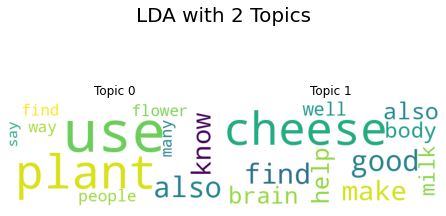

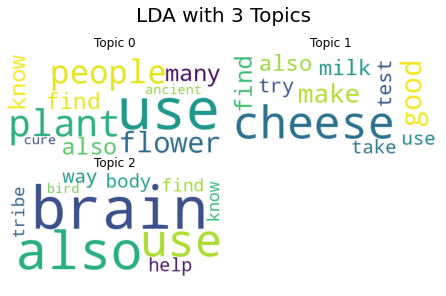

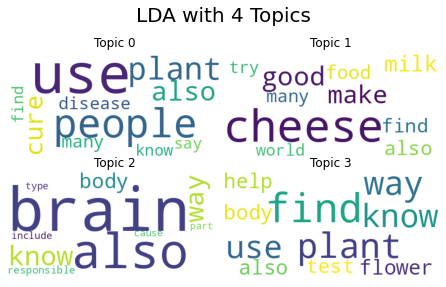

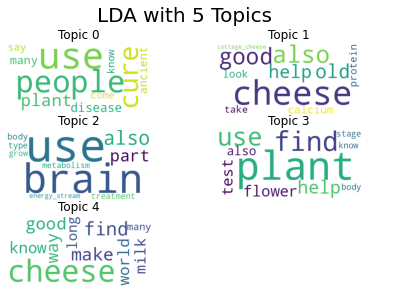

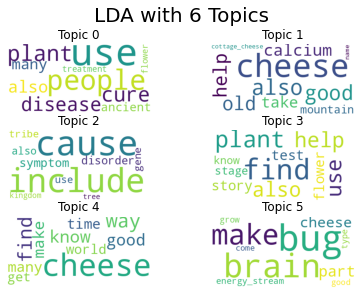

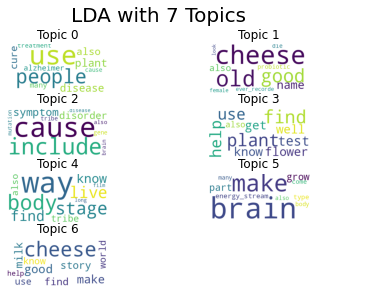

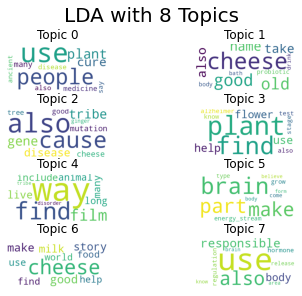

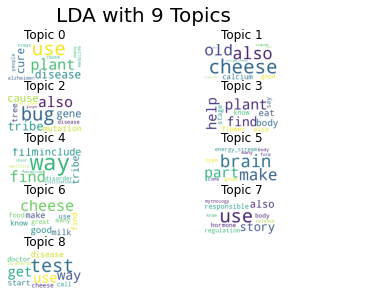

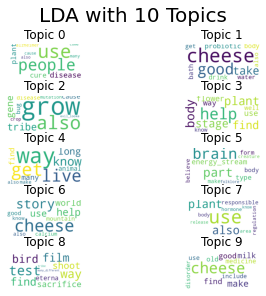

In [17]:
count = 2
for model in LDA_models:
    plot_wordcloud_from_lda(model,count)
    count += 1